#Описание данных

Набор данных состоит из списка популярных порталов недвижимости Мадрида с объектами недвижимости.

МЕСТО НАХОЖДЕНИЯ
Мадрид — один из самых посещаемых городов Европы как туристами, так и бизнесменами, здесь расположены штаб-квартиры многих крупных местных и транснациональных компаний. Поэтому Мадрид пользуется большим притоком как туристов, так и людей, стремящихся жить и работать в городе, чтобы повысить свою профессиональную карьеру.

ПРИВЛЕКАТЕЛЬНЫЕ ЦЕНЫ
Рынок недвижимости уже несколько лет находится в стадии роста, а это означает, что вы все еще можете найти объекты по очень привлекательным ценам (особенно по сравнению с другими европейскими столицами), но с хорошими шансами на повышение их стоимости в будущем.

ТИПЫ ДОМОВ
Индивидуальные дома не распространены в центре города, но есть в пригородах. В Мадриде также есть как новостройки, так и существующие квартиры. Цены на недвижимость в столицах, как правило, самые высокие в стране, но не в Испании. Стоимость недвижимости в Мадриде значительно ниже, чем в Барселоне и прибрежных районах.

#Подготовка данных

In [1]:
!pip install --quiet shap
!pip install --quiet catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.0 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import xgboost as xgb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/houses_Madrid.csv')

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
df.head(5)

,Unnamed: 0,id,title,subtitle,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,latitude,longitude,raw_address,is_exact_address_hidden,street_name,street_number,portal,floor,is_floor_under,door,neighborhood_id,operation,rent_price,rent_price_by_area,is_rent_price_known,buy_price,buy_price_by_area,is_buy_price_known,house_type_id,is_renewal_needed,is_new_development,built_year,has_central_heating,has_individual_heating,are_pets_allowed,has_ac,has_fitted_wardrobes,has_lift,is_exterior,has_garden,has_pool,has_terrace,has_balcony,has_storage_room,is_furnished,is_kitchen_equipped,is_accessible,has_green_zones,energy_certificate,has_parking,has_private_parking,has_public_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east
0,0,21742,"Piso en venta en calle de Godella, 64","San Cristóbal, Madrid",64.0,60.0,2,1.0,NaN,NaN,NaN,NaN,"Calle de Godella, 64",False,Calle de Godella,64,NaN,3,False,NaN,Neighborhood 135: San Cristóbal (1308.89 €/m2)...,sale,471,NaN,False,85000,1328,True,HouseType 1: Pisos,False,False,1960.0,NaN,NaN,NaN,True,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,False,NaN,NaN,NaN,NaN,False,True,False,False
1,1,21741,Piso en venta en calle de la del Manojo de Rosas,"Los Ángeles, Madrid",70.0,NaN,3,1.0,NaN,NaN,NaN,NaN,Calle de la del Manojo de Rosas,True,Calle de la del Manojo de Rosas,NaN,NaN,4,False,NaN,Neighborhood 132: Los Ángeles (1796.68 €/m2) -...,sale,666,NaN,False,129900,1856,True,HouseType 1: Pisos,True,False,NaN,NaN,NaN,NaN,NaN,True,True,True,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,en trámite,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,21740,"Piso en venta en calle del Talco, 68","San Andrés, Madrid",94.0,54.0,2,2.0,NaN,NaN,NaN,NaN,"Calle del Talco, 68",False,Calle del Talco,68,NaN,1,False,NaN,Neighborhood 134: San Andrés (1617.18 €/m2) - ...,sale,722,NaN,False,144247,1535,True,HouseType 1: Pisos,False,False,NaN,False,True,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,no indicado,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,21739,Piso en venta en calle Pedro Jiménez,"San Andrés, Madrid",64.0,NaN,2,1.0,NaN,NaN,NaN,NaN,Calle Pedro Jiménez,True,Calle Pedro Jiménez,NaN,NaN,Bajo,True,NaN,Neighborhood 134: San Andrés (1617.18 €/m2) - ...,sale,583,NaN,False,109900,1717,True,HouseType 1: Pisos,False,False,1955.0,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,True,NaN,NaN,True,NaN,en trámite,False,NaN,NaN,NaN,NaN,False,False,True,False
4,4,21738,Piso en venta en carretera de Villaverde a Val...,"Los Rosales, Madrid",108.0,90.0,2,2.0,NaN,NaN,NaN,NaN,Carretera de Villaverde a Vallecas,True,Carretera de Villaverde a Vallecas,NaN,NaN,4,False,NaN,Neighborhood 133: Los Rosales (1827.79 €/m2) -...,sale,1094,NaN,False,260000,2407,True,HouseType 1: Pisos,False,False,2003.0,NaN,NaN,NaN,True,True,True,True,NaN,True,NaN,NaN,True,NaN,NaN,NaN,True,en trámite,True,NaN,NaN,True,0.0,True,True,True,True


#Удаляем не нужные признаки:

In [7]:
df = df.drop(['Unnamed: 0', 'id', 'title', 'latitude','longitude','raw_address',
              'is_exact_address_hidden','street_number','portal', 'door',
              'rent_price_by_area','is_buy_price_known','are_pets_allowed',
              'is_furnished','is_kitchen_equipped','has_private_parking',
              'has_public_parking','operation','n_floors','sq_mt_allotment','sq_mt_useful',
              'rent_price','is_rent_price_known'],axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21742 entries, 0 to 21741
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   subtitle                      21742 non-null  object 
 1   sq_mt_built                   21616 non-null  float64
 2   n_rooms                       21742 non-null  int64  
 3   n_bathrooms                   21726 non-null  float64
 4   street_name                   15837 non-null  object 
 5   floor                         19135 non-null  object 
 6   is_floor_under                20572 non-null  object 
 7   neighborhood_id               21742 non-null  object 
 8   buy_price                     21742 non-null  int64  
 9   buy_price_by_area             21742 non-null  int64  
 10  house_type_id                 21351 non-null  object 
 11  is_renewal_needed             21742 non-null  bool   
 12  is_new_development            20750 non-null  object 
 13  b

#Проверяем данные на пропуски:

In [9]:
df.isna().mean()

subtitle                        0.000000
sq_mt_built                     0.005795
n_rooms                         0.000000
n_bathrooms                     0.000736
street_name                     0.271594
floor                           0.119906
is_floor_under                  0.053813
neighborhood_id                 0.000000
buy_price                       0.000000
buy_price_by_area               0.000000
house_type_id                   0.017984
is_renewal_needed               0.000000
is_new_development              0.045626
built_year                      0.540061
has_central_heating             0.374115
has_individual_heating          0.374115
has_ac                          0.484362
has_fitted_wardrobes            0.383727
has_lift                        0.109742
is_exterior                     0.139960
has_garden                      0.928433
has_pool                        0.762165
has_terrace                     0.560850
has_balcony                     0.847254
has_storage_room

#Исследуем отдельные признаки

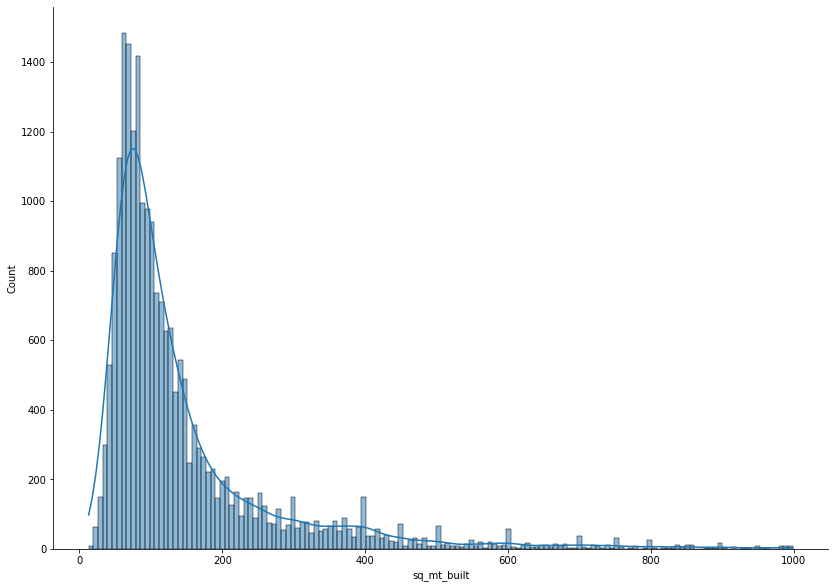

In [10]:
sns.displot (data = df['sq_mt_built'], kde= True, height=8.27, aspect=11.7/8.27)
plt.show()

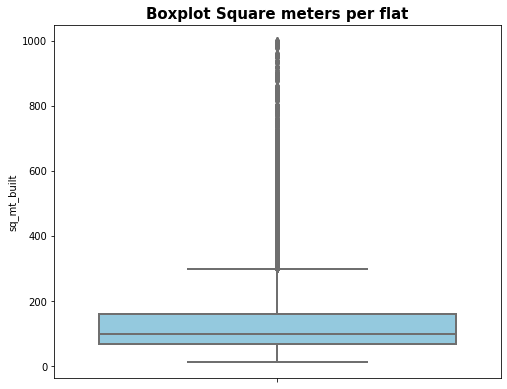

In [11]:
plt.figure(figsize=(8,6.5))
plt.title('Boxplot Square meters per flat', fontsize=15, fontweight='bold', fontname='DejaVu Sans', ha='center')
sns.boxplot(data = df, y="sq_mt_built",width = 0.8,
                    color = "skyblue",
                    linewidth = 2)
plt.show()

В признаке площади квартиры есть выбросы, удалим их.

In [12]:
df = df.loc[df['sq_mt_built']<400]

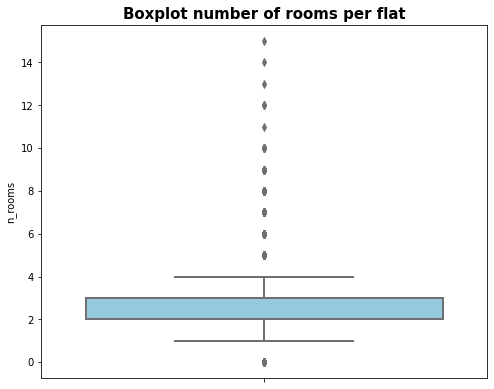

In [13]:
plt.figure(figsize=(8,6.5))
plt.title('Boxplot number of rooms per flat', fontsize=15, fontweight='bold', fontname='DejaVu Sans', ha='center')
sns.boxplot(data = df, y="n_rooms",width = 0.8,
                    color = "skyblue",
                    linewidth = 2)
plt.show()

В признаке количество комнат так же обнаружили выбросы, удалим их

In [14]:
df = df.loc[df['n_rooms']<10]

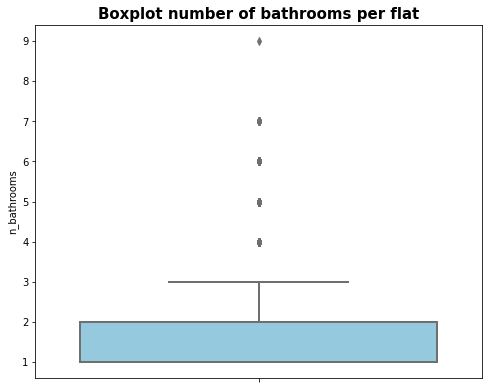

In [15]:
plt.figure(figsize=(8,6.5))
plt.title('Boxplot number of bathrooms per flat', fontsize=15, fontweight='bold', fontname='DejaVu Sans', ha='center')
sns.boxplot(data = df, y="n_bathrooms",width = 0.8,
                    color = "skyblue",
                    linewidth = 2)
plt.show()

В признаке количество ванных комнат обнаружены выбросы, удалим их

In [16]:
df = df.loc[df['n_bathrooms']<5]

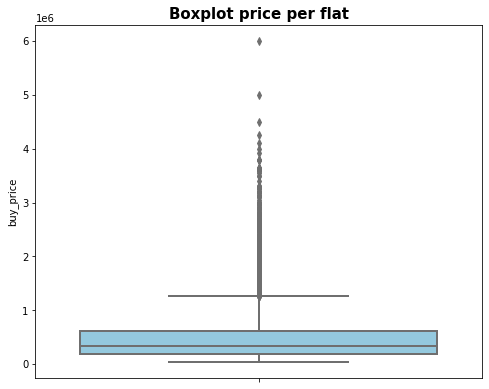

In [17]:
plt.figure(figsize=(8,6.5))
plt.title('Boxplot price per flat', fontsize=15, fontweight='bold', fontname='DejaVu Sans', ha='center')
sns.boxplot(data = df, y="buy_price",width = 0.8,
                    color = "skyblue",
                    linewidth = 2)
plt.show()

В целевом признаке есть выбросы, отбросим их

In [18]:
df = df.loc[df['buy_price']<2000000]

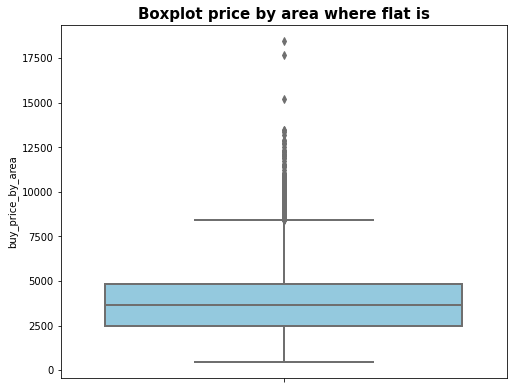

In [19]:
plt.figure(figsize=(8,6.5))
plt.title('Boxplot price by area where flat is', fontsize=15, fontweight='bold', fontname='DejaVu Sans', ha='center')
sns.boxplot(data = df, y="buy_price_by_area",width = 0.8,
                    color = "skyblue",
                    linewidth = 2)
plt.show()

#Создадим список из категориальных данных и заполним пропуски

In [20]:
cat_columns = list(df.select_dtypes(include=['object']).columns)

In [21]:
df[cat_columns] = df[cat_columns].fillna('no_info')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19397 entries, 0 to 21741
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   subtitle                      19397 non-null  object 
 1   sq_mt_built                   19397 non-null  float64
 2   n_rooms                       19397 non-null  int64  
 3   n_bathrooms                   19397 non-null  float64
 4   street_name                   19397 non-null  object 
 5   floor                         19397 non-null  object 
 6   is_floor_under                19397 non-null  object 
 7   neighborhood_id               19397 non-null  object 
 8   buy_price                     19397 non-null  int64  
 9   buy_price_by_area             19397 non-null  int64  
 10  house_type_id                 19397 non-null  object 
 11  is_renewal_needed             19397 non-null  bool   
 12  is_new_development            19397 non-null  object 
 13  b

По графику видно, что большинство дешевых квартир было построено псле 1950 года. Как правило старые дома находятся в центре города, а значит и цена на них выше.

In [23]:
df['built_year'].describe()

count    8866.000000
mean     1969.105685
std        72.865863
min      1723.000000
25%      1956.000000
50%      1970.000000
75%      1992.000000
max      8170.000000
Name: built_year, dtype: float64

В признаках года постройки дома и цена за парковочное место слишом много пропусков, которые нельзя заполнить.

In [24]:
df = df.drop(['built_year','parking_price'], axis=1)

# Исследуем признак этажность квартиры

In [25]:
df['floor'].value_counts()

1                       4228
2                       3321
3                       2828
4                       2178
Bajo                    2090
no_info                 1309
5                       1216
6                        849
7                        520
8                        304
Entreplanta exterior     227
9                        170
Semi-sótano exterior      54
Semi-sótano interior      36
Entreplanta interior      31
Sótano interior           23
Sótano                     5
Sótano exterior            4
Entreplanta                3
Semi-sótano                1
Name: floor, dtype: int64

In [26]:
list_floors_to_replace = ['Entreplanta exterior', 'Semi-sótano exterior',
       'Semi-sótano interior', 'Sótano interior', 'Entreplanta interior',
       'Sótano', 'Sótano exterior', 'Entreplanta','Semi-sótano']

Заменим дупликаты в столбце с этажами квартир

In [27]:
for i in list_floors_to_replace:
  df.loc[df['floor']==i,'floor'] = 'Bajo'

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19397 entries, 0 to 21741
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   subtitle                      19397 non-null  object 
 1   sq_mt_built                   19397 non-null  float64
 2   n_rooms                       19397 non-null  int64  
 3   n_bathrooms                   19397 non-null  float64
 4   street_name                   19397 non-null  object 
 5   floor                         19397 non-null  object 
 6   is_floor_under                19397 non-null  object 
 7   neighborhood_id               19397 non-null  object 
 8   buy_price                     19397 non-null  int64  
 9   buy_price_by_area             19397 non-null  int64  
 10  house_type_id                 19397 non-null  object 
 11  is_renewal_needed             19397 non-null  bool   
 12  is_new_development            19397 non-null  object 
 13  h

In [29]:
df['floor'].value_counts()

1          4228
2          3321
3          2828
Bajo       2474
4          2178
no_info    1309
5          1216
6           849
7           520
8           304
9           170
Name: floor, dtype: int64

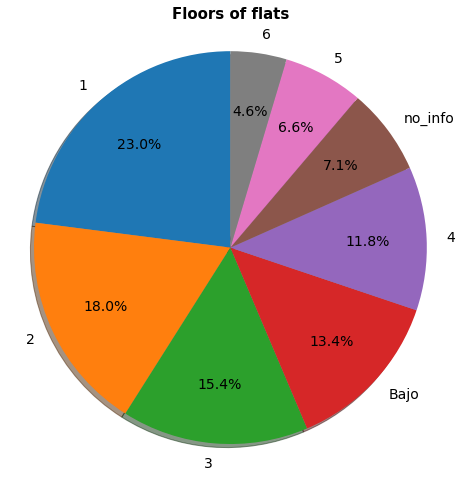

In [30]:
fig, ax = plt.subplots(figsize =(8, 9))
ax.pie(df['floor'].value_counts().head(8), labels=df['floor'].value_counts().head(8).index, autopct='%1.1f%%',
        shadow=True, startangle=90, pctdistance=0.7,labeldistance=1.1, rotatelabels=False,textprops={'fontsize': 14},radius=1.1)
plt.title('Floors of flats', fontsize=15, fontweight='bold', fontname='DejaVu Sans', ha='center')
plt.show()

По графику видно, что большинство квартир находится на первых трех этажах

In [31]:
df.groupby(['floor'])['buy_price'].agg({'count', 'median'}).reset_index()

,floor,count,median
0,1,4228,340000.0
1,2,3321,299000.0
2,3,2828,290000.0
3,4,2178,340000.0
4,5,1216,415000.0
5,6,849,499000.0
6,7,520,450000.0
7,8,304,495750.0
8,9,170,532500.0
9,Bajo,2474,199997.0


In [32]:
df.groupby(['floor'])['sq_mt_built'].agg({'count', 'median'}).reset_index()

,floor,count,median
0,1,4228,93.0
1,2,3321,90.0
2,3,2828,86.0
3,4,2178,91.0
4,5,1216,105.0
5,6,849,113.0
6,7,520,110.5
7,8,304,120.5
8,9,170,138.5
9,Bajo,2474,72.0


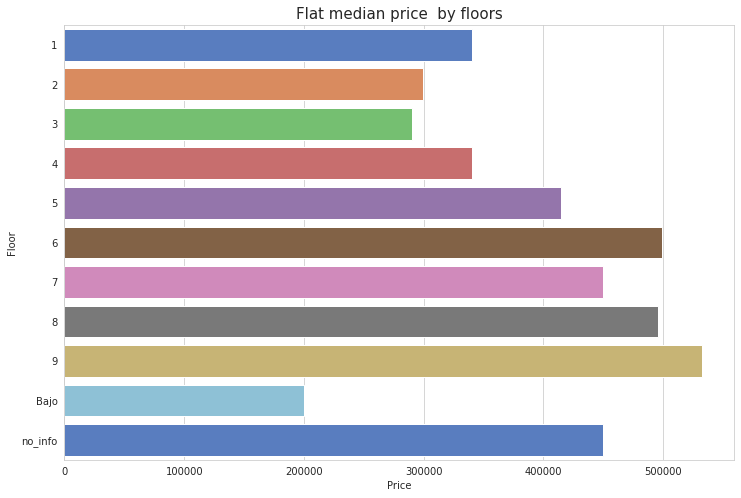

In [33]:
#Seaborn Horizontal barplot
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(x=df.groupby(['floor'])['buy_price'].median(), y=df.groupby(['floor'])['buy_price'].median().index, data=df,
palette="muted", errwidth=0)
ax.set_title("Flat median price  by floors", fontsize=15)
ax.set_xlabel ("Price")
ax.set_ylabel ("Floor")
plt.show()

Из графика видно, что первые этажи стоят меньше чем более высокие, не считая подвальных.

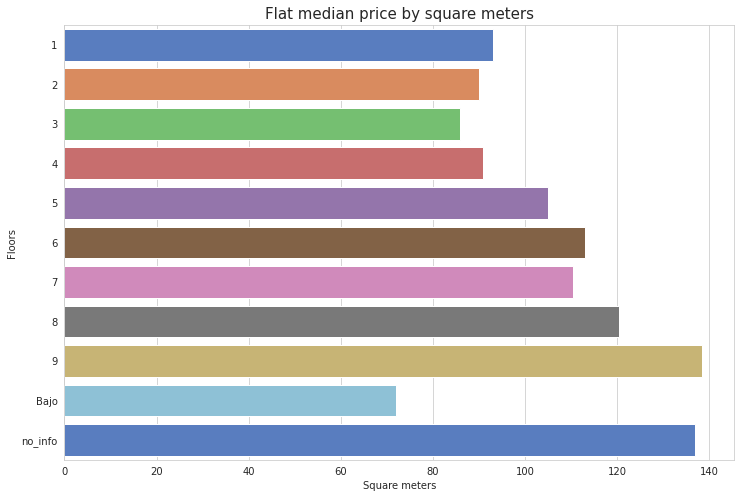

In [34]:
#Seaborn Horizontal barplot
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(x=df.groupby(['floor'])['sq_mt_built'].median(), y=df.groupby(['floor'])['sq_mt_built'].median().index, data=df,
palette="muted", errwidth=0)
ax.set_title("Flat median price by square meters", fontsize=15)
ax.set_xlabel ("Square meters")
ax.set_ylabel ("Floors")
plt.show()

Здесь видна зависимость площади квартиры от этажа. Чем выше этиж тем больше средняя площадь. 

In [35]:
df.groupby('floor')['buy_price_by_area'].median()

floor
1          3750.0
2          3635.0
3          3560.0
4          3841.0
5          4182.0
6          4286.0
7          4167.0
8          3971.0
9          3838.5
Bajo       2955.0
no_info    3097.0
Name: buy_price_by_area, dtype: float64

Из данных понятно, что цена за квадратный метр больше всего на 5-7 этажах, самые дешевые квартиры на цокольном этаже.

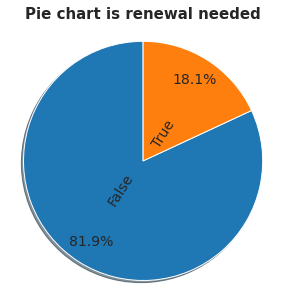

In [36]:

fig, ax = plt.subplots(figsize =(5, 5))
ax.pie(df['is_renewal_needed'].value_counts(), labels=df['is_renewal_needed'].value_counts().index, autopct='%1.1f%%',
        shadow=True, startangle=90, pctdistance=0.8,labeldistance=0.1, rotatelabels=True,textprops={'fontsize': 14},radius=1.1)
plt.title('Pie chart is renewal needed', fontsize=15, fontweight='bold', fontname='DejaVu Sans', ha='center')
plt.show()

По графику видно, что около 25 процентов домов нуждаются в реновации.

#Проверим данные на наличие явных дубликатов и удалим их

In [37]:
df = df.drop_duplicates(keep='first')

In [38]:
df.duplicated().sum()

0

#Построим корреляцию между признаками

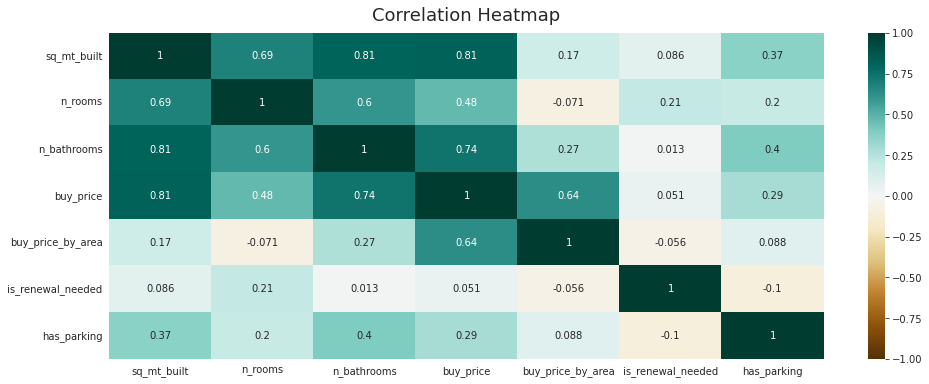

In [39]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

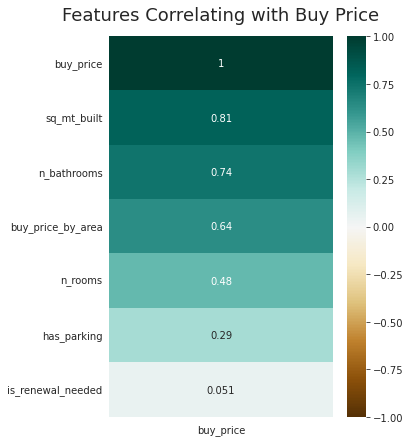

In [40]:
plt.figure(figsize=(5, 7))
heatmap = sns.heatmap(df.corr()[['buy_price']].sort_values(by='buy_price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Buy Price', fontdict={'fontsize':18}, pad=16);

По данным из корреляции видно, что на целевой признак больше всего влияют цена за квадратный метр, площадь квартиры, количество ванных комнах и общее число комнат.

In [41]:
df[['is_renewal_needed','has_parking']] = df[['is_renewal_needed','has_parking']].astype(int)

# Подготовим данные для кодирования и проведем его

In [42]:
cat_columns = list(df.select_dtypes(include=['object']).columns)

In [43]:
df.loc[:,cat_columns] = df.loc[:,cat_columns].astype(str)

In [44]:
enc = OrdinalEncoder()
df.loc[:,cat_columns] = enc.fit_transform(df.loc[:,cat_columns])

# Разделим данных для работы с моделью

In [45]:
features = df.drop('buy_price',axis=1)
target = df['buy_price']

In [46]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=42)

# Построим модели, с помощью валидации проверим их эффективность

In [47]:
def mae(y, y_pred):
    return (mean_absolute_error(y, y_pred))

def cv_mae(model):
    mae = -cross_val_score(model, features_train, target_train, scoring="neg_mean_absolute_error", cv=kf)
    return (mae)

In [48]:
kf = KFold(n_splits=3, random_state=42, shuffle=True)

cv_scores = []
cv_std = []

baseline_models = ['Linear_Reg.','Bayesian_Ridge_Reg.','LGBM_Reg.',
                   'Dec_Tree_Reg.','Random_Forest_Reg.', 'XGB_Reg.',
                   'Grad_Boost_Reg.','Cat_Boost_Reg.','Stacked_Reg.']

# Linear Regression

lreg = LinearRegression()
score_lreg = cv_mae(lreg)
cv_scores.append(score_lreg.mean())
cv_std.append(score_lreg.std())

# Bayesian Ridge Regression

brr = BayesianRidge(compute_score=True)
score_brr = cv_mae(brr)
cv_scores.append(score_brr.mean())
cv_std.append(score_brr.std())

# Light Gradient Boost Regressor

l_gbm = LGBMRegressor(objective='regression')
score_l_gbm = cv_mae(l_gbm)
cv_scores.append(score_l_gbm.mean())
cv_std.append(score_l_gbm.std())


# Decision Tree Regressor

dtr = DecisionTreeRegressor()
score_dtr = cv_mae(dtr)
cv_scores.append(score_dtr.mean())
cv_std.append(score_dtr.std())

# Random Forest Regressor

rfr = RandomForestRegressor()
score_rfr = cv_mae(rfr)
cv_scores.append(score_rfr.mean())
cv_std.append(score_rfr.std())

# XGB Regressor

xgb = xgb.XGBRegressor()
score_xgb = cv_mae(xgb)
cv_scores.append(score_xgb.mean())
cv_std.append(score_xgb.std())

# Gradient Boost Regressor

gbr = GradientBoostingRegressor()
score_gbr = cv_mae(gbr)
cv_scores.append(score_gbr.mean())
cv_std.append(score_gbr.std())

# Cat Boost Regressor

catb = CatBoostRegressor(verbose=False)
score_catb = cv_mae(catb)
cv_scores.append(score_catb.mean())
cv_std.append(score_catb.std())

# Stacked Regressor

stack_gen = StackingRegressor(regressors=(CatBoostRegressor(verbose=False),
                                          LinearRegression(),
                                          BayesianRidge(),
                                          GradientBoostingRegressor()),
                              meta_regressor = CatBoostRegressor(verbose=False),
                              use_features_in_secondary = True)

score_stack_gen = cv_mae(stack_gen)
cv_scores.append(score_stack_gen.mean())
cv_std.append(score_stack_gen.std())

final_cv_score = pd.DataFrame(baseline_models, columns = ['Regressors'])
final_cv_score['MAE_mean'] = cv_scores
final_cv_score['MAE_std'] = cv_std

[11:22:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:22:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:22:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [49]:
final_cv_score.sort_values(by='MAE_mean')

,Regressors,MAE_mean,MAE_std
7,Cat_Boost_Reg.,4335.353455,5.372060
8,Stacked_Reg.,4717.091410,121.496626
4,Random_Forest_Reg.,4893.173331,172.804969
2,LGBM_Reg.,7281.114508,106.146876
3,Dec_Tree_Reg.,10189.362518,259.686671
6,Grad_Boost_Reg.,13082.144908,217.286769
5,XGB_Reg.,13244.717444,507.296831
1,Bayesian_Ridge_Reg.,62895.141966,866.716260
0,Linear_Reg.,62929.463422,854.038449


Из таблицы видно, что самая результативная модель CatBoost, подберем параметры и оптимизируем модель

In [50]:
pip install --q optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 KB 19.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 17.0 MB/s eta 0:00:00


In [51]:
import optuna

In [52]:
param_cb = {
            "subsample": optuna.distributions.FloatDistribution (0.5, 0.99),
            'learning_rate': optuna.distributions.FloatDistribution (0.0001, 0.1)
            }
catb = CatBoostRegressor(verbose=False)
optuna_search = optuna.integration.OptunaSearchCV(catb,param_cb, cv=3, scoring='neg_mean_absolute_error',n_jobs=-1,n_trials=100)
optuna_search.fit(features_train, target_train)

<ipython-input-52-4d2e8df6602e>:6: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(catb,param_cb, cv=3, scoring='neg_mean_absolute_error',n_jobs=-1,n_trials=100)
[I 2023-01-15 11:23:01,332] A new study created in memory with name: no-name-ba71c431-1a39-4fe4-89dd-18a39339fbc8
[I 2023-01-15 11:23:28,804] Trial 1 finished with value: -4113.667301235529 and parameters: {'subsample': 0.7810585791715927, 'learning_rate': 0.0876262546651594}. Best is trial 1 with value: -4113.667301235529.
[I 2023-01-15 11:23:28,915] Trial 0 finished with value: -4245.955695786718 and parameters: {'subsample': 0.898083191294391, 'learning_rate': 0.06043983346223722}. Best is trial 1 with value: -4113.667301235529.
[I 2023-01-15 11:23:44,437] Trial 2 finished with value: -4418.6596922209455 and parameters: {'subsample': 0.587711593222549, 'learning_rate': 0.039832737161346984}. Best is tria

OptunaSearchCV(cv=3,
               estimator=<catboost.core.CatBoostRegressor object at 0x7fb7aaf1aa00>,
               n_jobs=-1, n_trials=100,
               param_distributions={'learning_rate': FloatDistribution(high=0.1, log=False, low=0.0001, step=None),
                                    'subsample': FloatDistribution(high=0.99, log=False, low=0.5, step=None)},
               scoring='neg_mean_absolute_error')

In [53]:
-optuna_search.best_score_

4016.9361118268826

In [54]:
best_params = optuna_search.best_params_

In [55]:
best_params

{'subsample': 0.9345166117490031, 'learning_rate': 0.09791295847378352}

Проверка на тестовой выборке с подобранными параметрами

In [56]:
catb_fin_model = CatBoostRegressor(verbose=100,
                                   random_seed=42,
                                   **best_params)
catb_fin_model.fit(features_train, target_train)
pred = catb_fin_model.predict(features_test)

0:	learn: 337826.2702090	total: 4.19ms	remaining: 4.19s
100:	learn: 13604.5025664	total: 318ms	remaining: 2.83s
200:	learn: 9785.7523996	total: 642ms	remaining: 2.55s
300:	learn: 7923.8384910	total: 948ms	remaining: 2.2s
400:	learn: 6813.1834991	total: 1.45s	remaining: 2.17s
500:	learn: 6003.6194912	total: 1.76s	remaining: 1.76s
600:	learn: 5358.4229999	total: 2.07s	remaining: 1.38s
700:	learn: 4870.4401338	total: 2.45s	remaining: 1.05s
800:	learn: 4464.8447503	total: 2.88s	remaining: 715ms
900:	learn: 4129.8420563	total: 3.2s	remaining: 352ms
999:	learn: 3842.9363428	total: 3.54s	remaining: 0us


In [57]:
mae(target_test, pred)

3775.75970672423

Ошибка в модели с подобранными параметрами optuna оказалась ниже

In [58]:
catb.fit(features_train, target_train)
pred1 = catb.predict(features_test)

In [59]:
mae(target_test, pred1)

4053.978814788158

#Общий вывод

Были выполнены шаги:

1) Выполнена предобработка: 
* удалены дубликаты
* обработаны аномалии, связанные с выбросами
* удалены признаки, не влияющие на цену или с большим количеством пропусков
* заполнены пропуски  

2) Проведен анализ признаков  
3) С помощью кросс-валидации выбрана лучшая модель и проведен поиск оптимальных параметров  
4) Проведено обучение и предсказание модели с параметрами по умолчанию и дополнительно с оптимизированными гиперпараметрами.

В качестве использования модели для предсказания цен на недвижимость рекомендуется выбрать CatBoost Regressor.

